In [ ]:
pip install mrjob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 kB 8.5 MB/s eta 0:00:00


In [ ]:
pip install scipy==1.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 24.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random
import operator
import math
import heapq
import itertools
import multiprocessing as mp
import datetime
import time
import threading
import queue
import os
from mrjob.job import MRJob
from mrjob.step import MRStep
from itertools import combinations
import argparse
from collections import defaultdict
import json

In [ ]:
df = pd.read_csv('star-wars-network-edges.csv')

In [ ]:
df1 = df[['source', 'target','weight']]

In [ ]:
G = nx.from_pandas_edgelist(df1,'source','target')

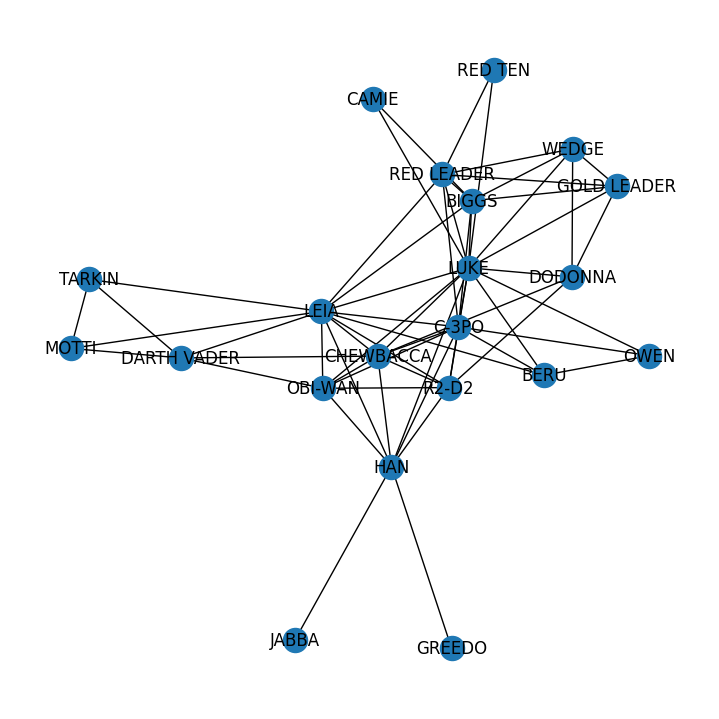

In [ ]:
figure(figsize=(7, 7))
nx.draw(G,with_labels = True)

In [ ]:

# Define the distance metric (in this case, shortest path distance)
def distance(node1, node2):
    return len(nx.shortest_path(G, node1, node2))

# Define the canopy clustering algorithm
def canopy_clustering(graph, t1, t2):
    # Initialize empty list of canopies
    canopies = []
    # Define a list of nodes to choose from
    nodes = list(graph.nodes())
    while nodes:
        # Choose a random node as a center node
        center_node = np.random.choice(nodes)
        
        # Find all nodes within distance t1 of the center node
        canopy_nodes = [n for n in nodes if distance(center_node, n) <= t1]
        
        # Add the canopy to the list of canopies
        canopies.append(canopy_nodes)
        # Remove the canopy nodes from the list of nodes
        nodes = [n for n in nodes if n not in canopy_nodes]
        
        # Remove all nodes within distance t2 of the center node
        nodes = [n for n in nodes if distance(center_node, n) > t2]
        
    return canopies


In [ ]:
import networkx as nx
import os
from mrjob.job import MRJob

class CanopyCluster(MRJob):
    def configure_args(self):
        super(CanopyCluster, self).configure_args()
        self.add_passthru_arg('--canopy_path', help='Path to file containing initial canopies')
        self.add_passthru_arg('--t1', help='T1 threshold for canopy clustering')
        self.add_passthru_arg('--t2', help='T2 threshold for canopy clustering')

    def mapper(self, _, line):
        # Parse input line to get node and neighbors
        node, neighbors = line.strip().split('\t')
        neighbors = set(neighbors.split(','))

        # Load canopies
        with open(self.options.canopy_path, 'r') as f:
            canopies = [set(line.strip().split(',')) for line in f]

        # Find the canopies that this node belongs to
        belonging_canopies = []
        for canopy in canopies:
            jaccard_sim = len(canopy.intersection(neighbors)) / len(canopy.union(neighbors))
            if jaccard_sim >= float(self.options.t1):
                belonging_canopies.append(','.join(canopy))

        # Emit (canopy, node) pairs
        for canopy in belonging_canopies:
            yield canopy, node

    def reducer(self, canopy, nodes):
        # Compute the centroid of this canopy
        nodes = list(nodes)
        centroid = nodes[0]
        if len(nodes) > 1:
            neighbors = set([n for node in nodes for n in nx.neighbors(graph, node)])
            for node in nodes:
                jaccard_sim = len(set(nx.neighbors(graph, node)).intersection(neighbors)) / len(set(nx.neighbors(graph, node)).union(neighbors))
                if jaccard_sim < float(self.options.t2):
                    centroid = node
                    break

        # Emit (centroid, canopy) pairs
        yield centroid, list(nodes)

def canopy_cluster_mapreduce(graph, t1, t2):
    # Write graph to file in adjacency list format
    input_file = 'graph.txt'
    with open(input_file, 'w') as f:
        for node in graph.nodes:
            neighbors = set(graph.neighbors(node))
            f.write(f'{node}\t{",".join(neighbors)}\n')

    # Compute initial canopies
    canopy_file = 'canopies.txt'
    canopies = []
    with open(canopy_file, 'w') as f:
        for node in graph.nodes:
            neighbors = set(graph.neighbors(node))
            canopy = set([node])
            for i, existing_canopy in enumerate(canopies):
                jaccard_sim = len(existing_canopy.intersection(neighbors)) / len(existing_canopy.union(neighbors))
                if jaccard_sim >= t1:
                    canopy.update(existing_canopy)
                    canopies[i] = canopy
            canopies.append(canopy)
            f.write(f'{",".join(canopy)}\n')

    # Set up job configuration
    mr_job = CanopyCluster(args=[input_file, '--canopy_path', canopy_file, '--t1', str(t1), '--t2', str(t2)])

    # Run job and collect output
    with mr_job.make_runner() as runner:
        runner.run()
        output = []
        for _, canopy in mr_job.parse_output(runner.cat_output()):
            output.append(canopy)

    # Remove input and output files
    os.remove(input_file)
    os.remove(canopy_file)

    return output


In [ ]:

def map_reduce(data, mapper, reducer):
    # Map phase: apply the mapper function to each data item and group the results by key
    mapped_data = {}
    for item in data:
        key, value = mapper(item)
        if key not in mapped_data:
            mapped_data[key] = []
        mapped_data[key].append(value)
        
    # Reduce phase: apply the reducer function to each group of items with the same key
    reduced_data = {}
    for key in mapped_data.keys():
        reduced_data[key] = reducer(key, mapped_data[key])
        
    return reduced_data

def mapper(node):
    # Define the key for the node based on its properties or connectivity pattern
    # Here, we use the degree of the node as the key
    key = G.degree(node)
    return (key, node)

def reducer(key, nodes):
    # Define a threshold distance for identifying canopies
    # Here, we use a distance of 2, meaning that nodes with degree difference <=2 are considered similar
    threshold = 2
    canopies = defaultdict(list)
    for node in nodes:
        added = False
        # Check if the node can be added to an existing canopy
        for canopy_key in canopies.keys():
            if abs(key - canopy_key) <= threshold:
                canopies[canopy_key].append(node)
                added = True
                break
        # If the node doesn't match any existing canopy, create a new one
        if not added:
            canopies[key].append(node)
    return canopies

can = map_reduce(G,mapper,reducer)
print(can)

{10: defaultdict(<class 'list'>, {10: ['C-3PO']}), 7: defaultdict(<class 'list'>, {7: ['R2-D2', 'OBI-WAN', 'BIGGS', 'RED LEADER']}), 15: defaultdict(<class 'list'>, {15: ['LUKE']}), 12: defaultdict(<class 'list'>, {12: ['LEIA']}), 8: defaultdict(<class 'list'>, {8: ['HAN', 'CHEWBACCA']}), 5: defaultdict(<class 'list'>, {5: ['DODONNA', 'DARTH VADER', 'GOLD LEADER', 'WEDGE']}), 2: defaultdict(<class 'list'>, {2: ['CAMIE', 'RED TEN']}), 4: defaultdict(<class 'list'>, {4: ['BERU']}), 3: defaultdict(<class 'list'>, {3: ['OWEN', 'MOTTI', 'TARKIN']}), 1: defaultdict(<class 'list'>, {1: ['GREEDO', 'JABBA']})}


In [ ]:
start = time.time()
canopies = canopy_clustering(G, t1=2, t2=1)
end = time.time()
print("Canopies:", canopies)


Canopies: [['C-3PO', 'R2-D2', 'LUKE', 'OBI-WAN', 'LEIA', 'HAN', 'CHEWBACCA', 'DODONNA', 'DARTH VADER'], ['CAMIE', 'BIGGS'], ['GREEDO'], ['BERU', 'OWEN'], ['MOTTI', 'TARKIN'], ['GOLD LEADER', 'WEDGE', 'RED LEADER', 'RED TEN'], ['JABBA']]


In [ ]:
subgraphs = []
for component in canopies:
  temp = nx.Graph()
  temp = G.subgraph(component)
  subgraphs.append(temp)

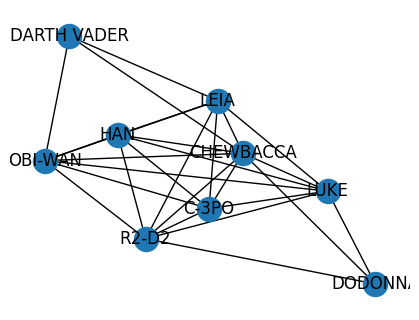

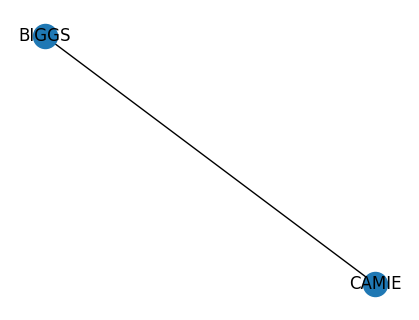

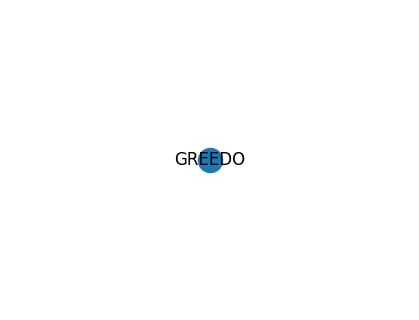

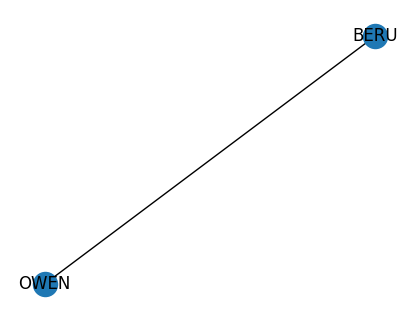

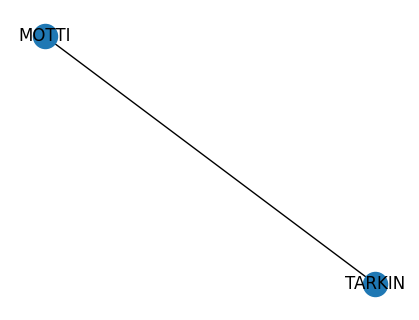

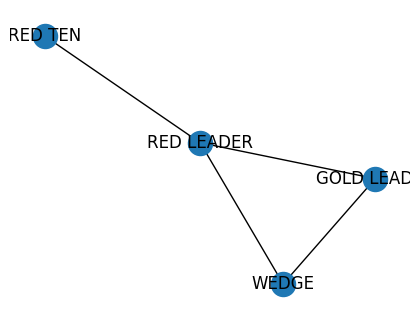

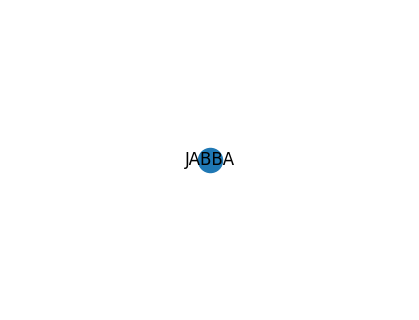

In [ ]:
for graph in subgraphs:
  figure(figsize=(4, 3))
  nx.draw(graph,with_labels = True)


In [ ]:
def calculate_edge_betweenness_centrality(subgraph):
    betweenness = {}
    for node in subgraph.nodes():
        stack = []
        pred = {w: [] for w in subgraph.nodes()}
        sigma = {w: 0 for w in subgraph.nodes()}
        distance = {w: -1 for w in subgraph.nodes()}
        sigma[node] = 1
        distance[node] = 0
        queue = [node]
        while queue:
            v = queue.pop(0)
            stack.append(v)
            for w in subgraph.neighbors(v):
                if distance[w] < 0:
                    queue.append(w)
                    distance[w] = distance[v] + 1
                if distance[w] == distance[v] + 1:
                    sigma[w] += sigma[v]
                    pred[w].append(v)
        delta = {v: 0 for v in subgraph.nodes()}
        while stack:
            w = stack.pop()
            for v in pred[w]:
                delta[v] += (sigma[v]/sigma[w]) * (1 + delta[w])
                if (v, w) in betweenness:
                    betweenness[(v, w)] += delta[v]
                elif (w, v) in betweenness:
                    betweenness[(w, v)] += delta[v]
                else:
                    betweenness[(v, w)] = delta[v]
    return betweenness

In [ ]:
def calculate_edge_betweenness_centrality_mt(G, sources, q):
    # Initialize variables
    betweenness = {e: 0 for e in G.edges()}
    stack = []
    sigma = {v: 0 for v in G.nodes()}
    distance = {v: -1 for v in G.nodes()}
    distance.update({v: 0 for v in sources})
    sigma.update({v: 1 for v in sources})
    
    # Breadth-first search
    queue = sources[:]
    while queue:
        v = queue.pop(0)
        stack.append(v)
        for w in G.neighbors(v):
            if distance[w] < 0:
                queue.append(w)
                distance[w] = distance[v] + 1
            if distance[w] == distance[v] + 1:
                sigma[w] += sigma[v]
    
    # Calculate betweenness
    delta = {v: 0 for v in G.nodes()}
    while stack:
        w = stack.pop()
        for v in G.neighbors(w):
            if distance[v] == distance[w] - 1:
                delta[v] += (sigma[v] / sigma[w]) * (1 + delta[w])
                if (v, w) in betweenness:
                    betweenness[(v, w)] += delta[v]
                else:
                    betweenness[(w, v)] += delta[v]
    
    # Add results to queue
    q.put(betweenness)

def calculate_edge_betweenness_centrality_parallel(G, n_threads=4):
    betweenness = {e: 0 for e in G.edges()}
    threads = []
    q = queue.Queue()
    sources = list(G.nodes())
    
    # Start threads
    for i in range(n_threads):
        t = threading.Thread(target=calculate_edge_betweenness_centrality_mt, args=(G, sources[i::n_threads], q))
        threads.append(t)
        t.start()
    
    # Wait for threads to finish and combine results
    for t in threads:
        t.join()
    
    while not q.empty():
        b = q.get()
        for e in b:
            betweenness[e] += b[e]
    
    return betweenness


In [ ]:
k=15

In [ ]:
comp_budget = {}
sg_budget = []

for graph in subgraphs:
  comp_budget[graph] = 0.5 * len(graph.nodes) + 0.5 * len(graph.edges)
sum = 0

for ind in comp_budget.values():
  sum += ind

result = {key: round(value * k / sum) for key, value in comp_budget.items()}  

i = 1
for j in result.values():
  print(i,"th component budget : ",j)
  i = i + 1
  sg_budget.append(j)

1 th component budget :  10
2 th component budget :  1
3 th component budget :  0
4 th component budget :  1
5 th component budget :  1
6 th component budget :  2
7 th component budget :  0


### Multi threading using ulrik brandes algorithm

In [ ]:
thread_count = len(subgraphs)
print(thread_count)

7


In [ ]:
import datetime
import time
import threading

class add_to_dict(threading.Thread):

    def __init__(self, lock, graph, kn, edge_list):
        threading.Thread.__init__(self)
        self.totalAdded = 0
        self.edge_list = edge_list
        self.lock = lock
        self.graph = graph
        self.kn = kn

    def run(self):        
            self.lock.acquire()
            if self.kn > 0:
              edge_bc = calculate_edge_betweenness_centrality(graph)
              sorted_edge_bc = dict( sorted(edge_bc.items(), key=operator.itemgetter(1),reverse=True))
              sorted_edge_bc2 = dict(itertools.islice(sorted_edge_bc.items(), self.kn))
              edge_list.update(sorted_edge_bc2)
            self.totalAdded += 1
            self.lock.release()                    


if __name__=="__main__":
    start = time.time()
    lock=threading.Lock()
    edge_list={}

    threads = [None] * thread_count
    
    i = 0
    for graph in subgraphs:
      threads[i] = add_to_dict(lock,graph,result[graph],edge_list)
      threads[i].start()
      i += 1

    for j in range(thread_count):
      threads[j].join()
    for item in edge_list.items():
      print(item)
    end = time.time()

(('R2-D2', 'C-3PO'), 17.333333333333332)
(('CHEWBACCA', 'C-3PO'), 17.0)
(('R2-D2', 'OBI-WAN'), 16.333333333333332)
(('CHEWBACCA', 'OBI-WAN'), 15.666666666666666)
(('LUKE', 'R2-D2'), 14.999999999999998)
(('LEIA', 'R2-D2'), 14.666666666666666)
(('LUKE', 'CHEWBACCA'), 13.666666666666666)
(('CHEWBACCA', 'HAN'), 13.333333333333332)
(('CHEWBACCA', 'R2-D2'), 12.666666666666664)
(('CHEWBACCA', 'DARTH VADER'), 12.333333333333334)
(('CAMIE', 'BIGGS'), 2.0)
(('OWEN', 'BERU'), 2.0)
(('MOTTI', 'TARKIN'), 2.0)
(('RED LEADER', 'WEDGE'), 7.0)
(('RED LEADER', 'RED TEN'), 6.0)


In [ ]:
print("Time for computation using multi threading in ulrik brandes",end-start)

Time for computation using multi threading in ulrik brandes 0.016138792037963867


In [ ]:
removable_edges = []
for key in edge_list.keys():
  removable_edges.append(key)
print(removable_edges)

[('R2-D2', 'C-3PO'), ('CHEWBACCA', 'C-3PO'), ('R2-D2', 'OBI-WAN'), ('CHEWBACCA', 'OBI-WAN'), ('LUKE', 'R2-D2'), ('LEIA', 'R2-D2'), ('LUKE', 'CHEWBACCA'), ('CHEWBACCA', 'HAN'), ('CHEWBACCA', 'R2-D2'), ('CHEWBACCA', 'DARTH VADER'), ('CAMIE', 'BIGGS'), ('OWEN', 'BERU'), ('MOTTI', 'TARKIN'), ('RED LEADER', 'WEDGE'), ('RED LEADER', 'RED TEN')]


In [ ]:
for edge in removable_edges:
  G.remove_edge(edge[0],edge[1])

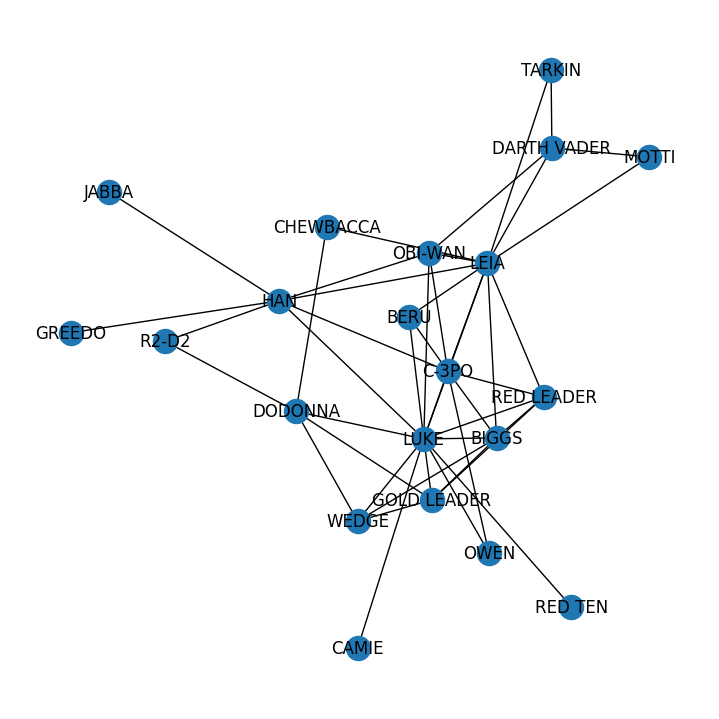

In [ ]:
figure(figsize=(7, 7))
nx.draw(G,with_labels = True)

In [ ]:
print(G.number_of_edges())

45


In [ ]:
from numpy.linalg import matrix_rank,eig

In [ ]:
def Connectivity(graph):
  A = nx.adjacency_matrix(graph)
  r = matrix_rank(A.todense())
  vals,v = eig(A.todense())
  # vals = nx.adjacency_spectrum(graph)
  sorted(vals,reverse = True)
  vals = vals[:r]
  # Using natural connectivity as the connectivity measure
  sum = 0
  for val in vals:
    sum += math.exp(val)
  nc = sum/len(vals)
  return nc

In [ ]:
print(Connectivity(G))

38.45862525433035


<ipython-input-27-334c94cc1470>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  sum += math.exp(val)
